# Setup

In [ ]:
import os

## Spark & Pyspark

In [ ]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget http://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install hyperopt mlflow pyngrok findspark xgboost==2.0.3 pyspark==3.4.1 cudf-cu11 --extra-index-url=https://pypi.nvidia.com

--2024-04-08 13:09:27--  http://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz [following]
--2024-04-08 13:09:27--  https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388341449 (370M) [application/x-gzip]
Saving to: ‘spark-3.4.1-bin-hadoop3.tgz’

spark-3.4.1-bin-had 100%[===================>] 370.35M  12.9MB/s    in 30s     

2024-04-08 13:09:59 (12.2 MB/s) - ‘spark-3.4.1-bin-hadoop3.tgz’ saved [388341449/388341449]

Looking in indexes: https://pypi.org/simple, https://pypi.nv

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .master('local[*]')
    .appName("model_experiment")
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.3")
    .config("spark.ui.port", "4050")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "16g")
    .getOrCreate()
)

## Paths Configs

In [ ]:
# path to the this notebook
# NOTE: Replace this with your project path if needed
PROJECT_PATH = (
    "/content/drive/My Drive/W210"
    if "google.colab" in str(get_ipython())
    else "."
)

# path to the data folder
# NOTE: Replace this with your data path if needed
DATA_PATH = f"{PROJECT_PATH}/data" if "google.colab" in str(get_ipython()) else PROJECT_PATH
# NOTE: For colab we use content so it doesn"t load on google drive storage
RAW_DATA_PATH = f"{PROJECT_PATH}/data" if "google.colab" in str(get_ipython()) else f"{PROJECT_PATH}/data"

## Colab Drive Mount

In [ ]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
os.chdir(PROJECT_PATH)

Mounted at /content/drive


## MLFlow and NGrok

In [ ]:
!export MLFLOW_TRACKING_URI=sqlite:///mlruns.db

In [ ]:
!nohup mlflow server --host 0.0.0.0 --port 5000 --backend-store-uri sqlite:///mlruns.db &

nohup: appending output to 'nohup.out'


In [ ]:
!pgrep mlflow

3296


In [ ]:
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
from google.colab import userdata
NGROK_AUTH_TOKEN = userdata.get('ngrok_token')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://9cc2-104-199-254-92.ngrok-free.app


## Python Libraries

In [ ]:
import itertools

from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import chain
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import mlflow
import mlflow.spark
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T
import sklearn.metrics as metrics

from hyperopt import hp, fmin, tpe, Trials, space_eval
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import DataFrame
from pyspark.sql.window import Window
from sklearn.base import BaseEstimator
from sklearn.calibration import calibration_curve
from sklearn.calibration import IsotonicRegression
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.utils import check_consistent_length
from sklearn.utils import column_or_1d
from synapse.ml.lightgbm import LightGBMClassifier
from xgboost.spark import SparkXGBRegressor
from tqdm import tqdm

---

# Definitions

## Transformation Pipeline

In [ ]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler


def build_transformation_pipeline(
    numerical_features: list,
    norm_features: list,
    sindex_cols: list,
    ohe_cols: list,
    labelCol: str = "shortage_flag",
    outputCol: str = "features",
) -> list:
    """
    Build a model pipeline including all possible feature transformations

    :param numerical_features: list of numerical features (to be normalized and imputed)
    :param norm_features: list of numerical features to be normalized
    :param sindex_cols: list of categorical features to be indexed
    :param ohe_cols: list of categorical features to be one-hot encoded
    :param labelCol: target label column name
    :param outputCol: output feature column name
    :return: list of spark pipeline stages
    """
    stages = list()

    # create StringIndexer for each text column
    if len(sindex_cols) > 0:
        indexers = StringIndexer(inputCols=sindex_cols, outputCols=[f"{c}_index" for c in sindex_cols])
        stages.append(indexers)
        icols = indexers.getOutputCols()
    else:
        icols = list()

    # create the one hot encoding
    if len(sindex_cols + ohe_cols) > 0:
        assembler_inputs = [f"{c}_ohe" for c in sindex_cols + ohe_cols]
        ohe = OneHotEncoder(inputCols=icols + ohe_cols, outputCols=assembler_inputs)
        stages.append(ohe)
    else:
        assembler_inputs = []

    # impute values
    if len(numerical_features) > 0:
        impute = Imputer(inputCols=numerical_features, outputCols=[f"{c}_nonnulls" for c in numerical_features])
        stages.append(impute)

    # normalize column values
    if len(norm_features) > 0:
        norm_assemble = VectorAssembler(inputCols=[f"{c}_nonnulls" for c in norm_features], outputCol="numerical")
        normalization = StandardScaler(inputCol="numerical", outputCol="normalized")
        stages += [norm_assemble, normalization]
        assembler_inputs += ["normalized"]

    # assemble the indexed columns into a single feature vector
    assembler_inputs += list(set(numerical_features) - set(norm_features))
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=outputCol)
    stages.append(assembler)

    return stages

## Cross-Validation

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import Optional, List, Tuple, Dict, Any

from pyspark import keyword_only
from pyspark.ml import Estimator
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.param import Params, Param, TypeConverters
from pyspark.ml.tuning import _ValidatorParams, _CrossValidatorParams
from pyspark.ml.tuning import CrossValidator


@F.udf(T.IntegerType())
def my_rand():
    return np.random.randint(1000)


def adjust_train_and_test(train_df, test_df):
    """
    Make sure that the train and test data do not share positive cases

    :param train_df: pyspark train data frame
    :param test_df: pyspark test data frame
    :return: train and test data frames adjusted for leakeage
    """
    train_ndc = train_df.filter(F.col("shortage_flag") == 1).groupBy("package_ndc").agg(F.sum("shortage_flag").alias("shortage_train"))
    test_ndc = test_df.filter(F.col("shortage_flag") == 1).groupBy("package_ndc").agg(F.sum("shortage_flag").alias("shortage_test"))

    join = train_ndc.join(test_ndc, on="package_ndc", how="inner").withColumn("rand", my_rand())
    remove_from_train = [
        r[0] for r in
        join.filter((F.col("shortage_test") > F.col("shortage_train")) | ((F.col("shortage_test") == F.col("shortage_train")) & (F.col("rand") >= 500)))
        .select("package_ndc")
        .collect()
    ]

    remove_from_test = [
        r[0] for r in
        join.filter(~F.col("package_ndc").isin(remove_from_train))
        .select("package_ndc")
        .collect()
    ]

    return (
        train_df.filter(~F.col("package_ndc").isin(remove_from_train)).cache(),
        test_df.filter(~F.col("package_ndc").isin(remove_from_test)).cache(),
    )


class _TimeSeriesCrossValidatorParams(_ValidatorParams):
    """
    Parameters used to define the TimeSeriesCrossValidator.
    """
    numFolds = Param(
        Params._dummy(),
        "numFolds",
        "number of folds for cross validation",
        typeConverter=TypeConverters.toInt,
    )

    foldCol = Param(
        Params._dummy(),
        "foldCol",
        "Param for the column name of user "
        + "specified fold number. Once this is specified, :py:class:`CrossValidator` "
        + "won't do random k-fold split. Note that this column should be integer type "
        + "with range [0, numFolds) and Spark will throw exception on out-of-range "
        + "fold numbers.",
        typeConverter=TypeConverters.toString,
    )

    dateCol = Param(
        Params._dummy(),
        "dateCol",
        "",
        typeConverter=TypeConverters.toString,
    )

    cvStartDate = Param(
        Params._dummy(),
        "cvStartDate",
        "",
        typeConverter=TypeConverters.toString,
    )

    cvEndDate = Param(
        Params._dummy(),
        "cvEndDate",
        "",
        typeConverter=TypeConverters.toString,
    )

    cvValSize = Param(
        Params._dummy(),
        "cvValSize",
        "",
        typeConverter=TypeConverters.toString
    )

    cvValStep = Param(
        Params._dummy(),
        "cvValStep",
        "",
        typeConverter=TypeConverters.toString
    )

    def __init__(self, *args: Any):
        super(_CrossValidatorParams, self).__init__(*args)
        self._setDefault(dateCol="cd_day")
        self._setDefault(cvStartDate="2022-02-01")
        self._setDefault(cvEndDate="2022-03-15")
        self._setDefault(cvValSize="weeks=2")
        self._setDefault(cvValStep="weeks=2")
        self._setDefault(numFolds=3, foldCol="")


class TimeSeriesCrossValidator(_TimeSeriesCrossValidatorParams, CrossValidator):
    """
    The TimeSeriesCrossValidator class runs sequential time series cross validation
    within the spark ml framework given configurations about how to run the
    cross validation.
    """
    _input_kwargs: Dict[str, Any]

    @keyword_only
    def __init__(
        self,
        *,
        estimator: Optional[Estimator] = None,
        estimatorParamMaps: Optional[List["ParamMap"]] = None,
        evaluator: Optional[Evaluator] = None,
        numFolds: int = 3,
        seed: Optional[int] = None,
        parallelism: int = 1,
        collectSubModels: bool = False,
        foldCol: str = "",
        dateCol: str = "",
        cvStartDate: str = "",
        cvEndDate: str = "",
        cvValSize: str = "",
        cvValStep: str = "",
    ) -> None:
        """
        Initialize the time series cross validator

        :param estimator: estimator object to train
        :param estimatorParamMaps: parameter grid to run over cross validation
        :param evaluator: model evaluation
        :param numFolds: number of folds to create (NOT USED)
        :param seed: random seed
        :param parallelism: number of parallel jobs
        :param collectSubModels: whether to collect sub models
        :param foldCol: column name of user specified fold number
        :param dateCol: column name of date
        :param cvStartDate: start date of cross validation
        :param cvEndDate: end date of cross validation
        :param cvValSize: size of validation set (weeks=X, months=X, years=X)
        """
        super(TimeSeriesCrossValidator, self).__init__()
        self._setDefault(parallelism=1)
        self._setDefault(dateCol="cd_day")
        self._setDefault(cvStartDate="20220201")
        self._setDefault(cvEndDate="20220315")
        self._setDefault(cvValSize="weeks=2")
        self._setDefault(cvValStep="weeks=2")
        self._setDefault(numFolds=3)
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def _kFold(self, dataset: DataFrame) -> List[Tuple[DataFrame, DataFrame]]:
        """
        Given a dataset, creates the train and test splits for each fold

        :param dataset: dataset to split
        :return: list of train and test splits
        """
        # get the parameters
        dateCol = self.getOrDefault(self.dateCol)
        cvStartDate = self.getOrDefault(self.cvStartDate)
        cvEndDate = self.getOrDefault(self.cvEndDate)
        cvValSize = self.getOrDefault(self.cvValSize)
        cvValStep = self.getOrDefault(self.cvValStep)
        numFolds = self.getOrDefault(self.numFolds)

        # convert cvValSize type
        k = cvValSize.split("=")[0]
        v = int(cvValSize.split("=")[1])
        cvValSize = relativedelta(**{k: v})

        # convert cvValStep type
        k = cvValStep.split("=")[0]
        v = int(cvValStep.split("=")[1])
        cvValStep = relativedelta(**{k: v})

        # calculate the list of dates to be used
        date_format = "%Y%m%d"
        start_date = datetime.strptime(cvStartDate, date_format)
        end_date = datetime.strptime(cvEndDate, date_format)
        validation_list = []
        count = 0
        while start_date < end_date:
            validation_list.append(
                (
                    start_date.strftime(date_format),
                    (start_date + cvValSize).strftime(date_format)
                )
            )
            start_date += cvValStep
            count += 1
            if count == numFolds:
                break

        # Do k-fold split.
        datasets = []
        for i, (train_end_time, validation_end_time) in enumerate(validation_list):
            # split the data between train and test
            train = dataset.filter(F.col(dateCol) < train_end_time)
            validation = dataset.filter(
                (F.col(dateCol) >= train_end_time) & (F.col(dateCol) < validation_end_time)
            )

            # adjust for leakage
            train, validation = adjust_train_and_test(train, validation)
            train = train.cache()
            validation = validation.cache()

            # save data frames
            datasets.append((train, validation))

        return datasets

## Metrics Calculations

In [ ]:
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import DataFrame


def get_all_metrics(model: Pipeline, test_data: DataFrame, labelCol: str = "shortage_flag") -> dict:
    """
    Given a model pipeline and data to be evaluated against, get a dictionary
    with binary classification metrics for that trained pipeline

    :param model: spark pipeline modelo
    :param test_data: spark data frame with test data
    :param labelCol: label column name
    :return: dictionary with metrics (precision, recall, f1, auc)
    """
    metrics_dict = dict()

    # create the prediction data frame
    prediction = model.transform(test_data).withColumn(labelCol, F.col(labelCol).cast("double"))

    # get the multi-class metrics
    mmetrics = MulticlassMetrics(prediction.select("prediction", labelCol).rdd)
    metrics_dict["precision_0"] = mmetrics.precision(0)
    metrics_dict["precision_1"] = mmetrics.precision(1)
    metrics_dict["recall_0"] = mmetrics.recall(0)
    metrics_dict["recall_1"] = mmetrics.recall(1)
    metrics_dict["f1_0"] = mmetrics.fMeasure(0.0)
    metrics_dict["f1_1"] = mmetrics.fMeasure(1.0)

    # get the area under the curve
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol=labelCol)
    metrics_dict["auc"] = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})

    return metrics_dict

## Extract Probabilities

In [ ]:
import pyspark.sql.functions as F
import pyspark.sql.types as T


def extract_prob(v):
    try:
        return float(v[1])
    except ValueError:
        return None
extract_prob_udf = F.udf(extract_prob, T.DoubleType())

## Calibration

In [ ]:
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.base import BaseEstimator
from sklearn.utils import check_consistent_length
from sklearn.utils import column_or_1d
from sklearn.calibration import calibration_curve
from sklearn.calibration import IsotonicRegression
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression


def compute_calibration_error(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int=15,
    round_digits: int=4
) -> float:
    """
    Computes the calibration error for binary classification via binning
    data points into the specified number of bins. Samples with similar
    ``y_prob`` will be grouped into the same bin. The bin boundary is
    determined by having similar number of samples within each bin.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.

    round_digits : int, default 4
        Round the calibration error metric.

    Returns
    -------
    calibration_error : float
        RMSE between the average positive label and predicted probability
        within each bin.
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, n_bins)

    # looping shouldn't be a source of bottleneck as n_bins should be a small number.
    bin_errors = 0.0
    for bin_y_true, bin_y_prob in zip(binned_y_true, binned_y_prob):
        avg_y_true = np.mean(bin_y_true)
        avg_y_score = np.mean(bin_y_prob)
        bin_error = (avg_y_score - avg_y_true) ** 2
        bin_errors += bin_error * len(bin_y_true)

    calibration_error = np.sqrt(bin_errors / len(y_true))
    return round(calibration_error, round_digits)


def create_binned_data(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Bin ``y_true`` and ``y_prob`` by distribution of the data.
    i.e. each bin will contain approximately an equal number of
    data points. Bins are sorted based on ascending order of ``y_prob``.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data.

    Returns
    -------
    binned_y_true/binned_y_prob : 1d ndarray
        Each element in the list stores the data for that bin.
    """
    sorted_indices = np.argsort(y_prob)
    sorted_y_true = y_true[sorted_indices]
    sorted_y_prob = y_prob[sorted_indices]
    binned_y_true = np.array_split(sorted_y_true, n_bins)
    binned_y_prob = np.array_split(sorted_y_prob, n_bins)
    return binned_y_true, binned_y_prob


def get_bin_boundaries(binned_y_prob: List[np.ndarray]) -> np.ndarray:
    """
    Given ``binned_y_prob`` from ``create_binned_data`` get the
    boundaries for each bin.

    Parameters
    ----------
    binned_y_prob : list
        Each element in the list stores the data for that bin.

    Returns
    -------
    bins : 1d ndarray
        Boundaries for each bin.
    """
    bins = []
    for i in range(len(binned_y_prob) - 1):
        last_prob = binned_y_prob[i][-1]
        next_first_prob = binned_y_prob[i + 1][0]
        bins.append((last_prob + next_first_prob) / 2.0)

    bins.append(1.0)
    return np.array(bins)


def compute_binary_score(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    round_digits: int=4
) -> Dict[str, float]:
    """
    Compute various evaluation metrics for binary classification.
    Including auc, precision, recall, f1, log loss, brier score. The
    threshold for precision and recall numbers are based on the one
    that gives the best f1 score.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    round_digits : int, default 4
        Round the evaluation metric.

    Returns
    -------
    metrics_dict : dict
        Metrics are stored in key value pair. ::

        {
            'auc': 0.82,
            'precision': 0.56,
            'recall': 0.61,
            'f1': 0.59,
            'log_loss': 0.42,
            'brier': 0.12
        }
    """
    auc = round(metrics.roc_auc_score(y_true, y_prob), round_digits)
    log_loss = round(metrics.log_loss(y_true, y_prob), round_digits)
    brier_score = round(metrics.brier_score_loss(y_true, y_prob), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier_score
    }


def compute_calibration_summary(
    eval_dict: Dict[str, pd.DataFrame],
    label_col: str='label',
    score_col: str='score',
    n_bins: int=15,
    strategy: str='quantile',
    round_digits: int=4,
    show: bool=True,
    save_plot_path: Optional[str]=None
) -> pd.DataFrame:
    """
    Plots the calibration curve and computes the summary statistics for the model.

    Parameters
    ----------
    eval_dict : dict
        We can evaluate multiple calibration model's performance in one go. The key
        is the model name used to distinguish different calibration model, the value
        is the dataframe that stores the binary true targets and the predicted score
        for the positive class.

    label_col : str
        Column name for the dataframe in ``eval_dict`` that stores the binary true targets.

    score_col : str
        Column name for the dataframe in ``eval_dict`` that stores the predicted score.

    n_bins : int, default 15
        Number of bins to discretize the calibration curve plot and calibration error statistics.
        A bigger number requires more data, but will be closer to the true calibration error.

    strategy : {'uniform', 'quantile'}, default 'quantile'
        Strategy used to define the boundary of the bins.

        - uniform: The bins have identical widths.
        - quantile: The bins have the same number of samples and depend on the predicted score.

    round_digits : default 4
        Round the evaluation metric.

    show : bool, default True
        Whether to show the plots on the console or jupyter notebook.

    save_plot_path : str, default None
        Path where we'll store the calibration plot. None means it will not save the plot.

    Returns
    -------
    df_metrics : pd.DataFrame
        Corresponding metrics for all the input dataframe.
    """

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics stores list of dict, e.g.
    # [{'auc': 0.776, 'name': 'xgb'}]
    estimator_metrics = []
    for name, df_eval in eval_dict.items():
        prob_true, prob_pred = calibration_curve(
            df_eval[label_col],
            df_eval[score_col],
            n_bins=n_bins,
            strategy=strategy
        )

        calibration_error = compute_calibration_error(
            df_eval[label_col], df_eval[score_col], n_bins, round_digits
        )
        metrics_dict = compute_binary_score(df_eval[label_col], df_eval[score_col], round_digits)
        metrics_dict['calibration_error'] = calibration_error
        metrics_dict['name'] = name
        estimator_metrics.append(metrics_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(df_eval[score_col], range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='perfect')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='upper left', ncol=2)
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()
    if show:
        plt.show()

    if save_plot_path is not None:
        save_dir = os.path.dirname(save_plot_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        fig.savefig(save_plot_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics



class HistogramCalibrator(BaseEstimator):
    """
    Bins the data based on equal size interval (each bin contains approximately
    equal size of samples).

    Parameters
    ----------
    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.

    Attributes
    ----------
    bins_ : 1d ndarray
        Boundaries for each bin.

    bins_score_ : 1d ndarray
        Calibration score for each bin.
    """

    def __init__(self, n_bins: int=15):
        self.n_bins = n_bins

    def fit(self, y_prob: np.ndarray, y_true: np.ndarray):
        """
        Learns the bin boundaries and calibration score for each bin.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        y_true : 1d ndarray
            Binary true targets.

        Returns
        -------
        self
        """
        binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, self.n_bins)
        self.bins_ = get_bin_boundaries(binned_y_prob)
        self.bins_score_ = np.array([np.mean(value) for value in binned_y_true])
        return self

    def predict(self, y_prob: np.ndarray) -> np.ndarray:
        """
        Predicts the calibrated probability.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        indices = np.searchsorted(self.bins_, y_prob)
        return self.bins_score_[indices]


class PlattCalibrator(BaseEstimator):
    """
    Boils down to applying a Logistic Regression.

    Parameters
    ----------
    log_odds : bool, default True
        Logistic Regression assumes a linear relationship between its input
        and the log-odds of the class probabilities. Converting the probability
        to log-odds scale typically improves performance.

    Attributes
    ----------
    coef_ : ndarray of shape (1,)
        Binary logistic regression's coefficient.

    intercept_ : ndarray of shape (1,)
        Binary logistic regression's intercept.
    """

    def __init__(self, log_odds: bool=True):
        self.log_odds = log_odds

    def fit(self, y_prob: np.ndarray, y_true: np.ndarray):
        """
        Learns the logistic regression weights.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        y_true : 1d ndarray
            Binary true targets.

        Returns
        -------
        self
        """
        self.fit_predict(y_prob, y_true)
        return self

    @staticmethod
    def _convert_to_log_odds(y_prob: np.ndarray) -> np.ndarray:
        eps = 1e-12
        y_prob = np.clip(y_prob, eps, 1 - eps)
        y_prob = np.log(y_prob / (1 - y_prob))
        return y_prob

    def predict(self, y_prob: np.ndarray) -> np.ndarray:
        """
        Predicts the calibrated probability.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        output = self._transform(y_prob)
        return output

    def _transform(self, y_prob: np.ndarray) -> np.ndarray:
        output = y_prob * self.coef_[0] + self.intercept_
        output = 1 / (1 + np.exp(-output))
        return output

    def fit_predict(self, y_prob: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """
        Chain the .fit and .predict step together.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        y_true : 1d ndarray
            Binary true targets.

        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        # the class expects 2d ndarray as input features
        logistic = SklearnLogisticRegression(C=1e10, solver='lbfgs')
        logistic.fit(y_prob.reshape(-1, 1), y_true)
        self.coef_ = logistic.coef_[0]
        self.intercept_ = logistic.intercept_

        y_calibrated_prob = self._transform(y_prob)
        return y_calibrated_prob


class PlattHistogramCalibrator(PlattCalibrator):
    """
    Boils down to first applying a Logistic Regression then perform
    histogram binning.

    Parameters
    ----------
    log_odds : bool, default True
        Logistic Regression assumes a linear relationship between its input
        and the log-odds of the class probabilities. Converting the probability
        to log-odds scale typically improves performance.

    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.

    Attributes
    ----------
    coef_ : ndarray of shape (1,)
        Binary logistic regresion's coefficient.

    intercept_ : ndarray of shape (1,)
        Binary logistic regression's intercept.

    bins_ : 1d ndarray
        Boundaries for each bin.

    bins_score_ : 1d ndarray
        Calibration score for each bin.
    """

    def __init__(self, log_odds: bool=True, n_bins: int=15):
        super().__init__(log_odds)
        self.n_bins = n_bins

    def fit(self, y_prob: np.ndarray, y_true: np.ndarray):
        """
        Learns the logistic regression weights and the
        bin boundaries and calibration score for each bin.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        y_true : 1d ndarray
            Binary true targets.

        Returns
        -------
        self
        """
        y_prob_platt = super().fit_predict(y_prob, y_true)
        binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob_platt, self.n_bins)
        self.bins_ = get_bin_boundaries(binned_y_prob)
        self.bins_score_ = np.array([np.mean(value) for value in binned_y_prob])
        return self

    def predict(self, y_prob: np.ndarray) -> np.ndarray:
        """
        Predicts the calibrated probability.

        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.

        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        y_prob_platt = super().predict(y_prob)
        indices = np.searchsorted(self.bins_, y_prob_platt)
        return self.bins_score_[indices]

---

# Configurations

In [ ]:
EXPERIMENT_TAG = "evaluate"
DATASET_TARGET = "24M"
WEEKS_AHEAD = 4
NUM_EVALS = 25

FEATURES = [
    "quarter",
    "recalls",
    "inspections",
    "in_vai",
    "in_oai",
    "compliances",
    "in_injunction",
    # "in_seizure",
    "adverse_events",
    "in_labeler_shortage",
    # "pct_shortage",
    "age",
    "shortage_indicator",
    "dosage_implantable",
    "dosage_inhalable",
    "dosage_injectable",
    "dosage_liquid",
    "dosage_miscellaneous",
    "dosage_ophthalmic",
    "dosage_oral_care",
    "dosage_oral_solid",
    "dosage_rectal",
    "dosage_topical",
    "dosage_transdermal",
    "dosage_vaginal",
    "mc_anda",
    "mc_bla",
    "mc_bulk_ingredient",
    "mc_bulk_ingredient_for_human_prescription_compounding",
    "mc_cosmetic",
    "mc_drug_for_further_processing",
    "mc_emergency_use_authorization",
    "mc_export_only",
    "mc_nda",
    "mc_nda_authorized_generic",
    "mc_otc_monograph_drug",
    "mc_otc_monograph_final",
    "mc_otc_monograph_not_final",
    "mc_unapproved_drug_for_use_in_drug_shortage",
    "mc_unapproved_drug_other",
    "mc_unapproved_homeopathic",
    "mc_unapproved_medical_gas",
    "route_auricularotic",
    "route_enteral",
    "route_extracorporeal",
    "route_infiltration",
    "route_intraarticular",
    "route_intracardiac",
    "route_intracaudal",
    "route_intracavernous",
    "route_intracavitary",
    "route_intradermal",
    "route_intraluminal",
    "route_intralymphatic",
    "route_intramedullary",
    "route_intrameningeal",
    "route_intraperitoneal",
    "route_intrapleural",
    "route_intrasinal",
    "route_intraspinal",
    "route_intrasynovial",
    "route_intratympanic",
    "route_intrauterine",
    "route_intravascular",
    "route_intraventricular",
    "route_intravesical",
    "route_mucosal",
    "route_ophthalmic",
    "route_parenteral",
    "route_perineural",
    "route_respiratory",
    "route_topical",
    "route_ureteral",
    "route_urethral",
    "route_vaginal",
]
STRING_INDEX = []
OHE_FEATURES = []
NORM_FEATURES =  [
    "recalls",
    "inspections",
    "compliances",
    "adverse_events",
    "age",
]
NUMERICAL_FEATURES = list(set(FEATURES) - set(STRING_INDEX) - set(OHE_FEATURES))

MIN_DATE = "20220601"
if DATASET_TARGET == "3M":
    START_CV_DATE = "20220201"
    END_CV_DATE = "20220315"
    END_TEST_DATE = "20220401"
    CV_SET_SIZE = "weeks=2"
    CV_SET_STEP = "weeks=2"
    NUM_FOLDS = 3
elif DATASET_TARGET == "12M":
    START_CV_DATE = "20220801"
    END_CV_DATE = "20230101"
    END_TEST_DATE = "20230201"
    CV_SET_SIZE = "months=1"
    CV_SET_STEP = "months=1"
    NUM_FOLDS = 5
elif DATASET_TARGET == "24M":
    START_CV_DATE = "20230201"
    END_CV_DATE = "20230801"
    END_TEST_DATE = "20240101"
    CV_SET_SIZE = "months=4"
    CV_SET_STEP = "months=1"
    NUM_FOLDS = 3

ALGORITHMS = [
    LogisticRegression,
    LinearSVC,
    RandomForestClassifier,
    GBTClassifier,
    SparkXGBRegressor,
]

GRID_SPACE = {
    LogisticRegression: {
        "maxIter": hp.qloguniform("maxIter", np.log(10), np.log(1000),10),
        "regParam": hp.loguniform("regParam", np.log(1e-07), np.log(1e-04)),
        "elasticNetParam": hp.uniform("elasticNetParam", 0, 1),
        "labelCol": "shortage_flag",
    },
    LinearSVC: {
        "maxIter": hp.qloguniform("maxIter", np.log(10), np.log(1000), 10),
        "regParam": hp.loguniform("regParam", np.log(1e-07), np.log(1e-04)),
        "tol": hp.choice("tol", [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]),
        "standardization": hp.choice("standardization", [False]),
        "labelCol": "shortage_flag",
    },
    RandomForestClassifier: {
        "numTrees": hp.quniform('numTrees', 10, 100, 10),
        "featureSubsetStrategy":  hp.choice("featureSubsetStrategy" ,['auto', 'all']),
        "impurity": hp.choice("impurity", ['entropy', 'gini']),
        "maxBins": hp.choice("maxBins", [32, 64, 128]),
        "maxDepth": hp.quniform('maxDepth', 7, 30, 1),
        "labelCol": "shortage_flag",
        "seed": hp.choice("seed", [42]),
        # "bootstrap": [True, False],
        # "checkpointInterval": [10, 20],
        # "minInfoGain": [0.0, 0.001, 0.0001],
        # "minInstancesPerNode": [1, 5],
        # "subsamplingRate": [0.7, 1.0],
    },
    GBTClassifier: {
        'maxDepth': hp.quniform('maxDepth', 7, 30, 1),
        "featureSubsetStrategy":  hp.choice("featureSubsetStrategy" ,['auto', 'all']),
        'maxIter': hp.choice('maxIter', [10, 20, 30]),
        'stepSize': hp.loguniform('stepSize', -5, 0),
        # 'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 50, 1),
        # 'subsamplingRate': hp.quniform('subsamplingRate', .01, 1, .05),
        "seed": hp.choice("seed", [42]),
        "labelCol": "shortage_flag",

    },
    LightGBMClassifier: {
        'learningRate': hp.loguniform("learningRate", np.log(1e-03), np.log(1e-1)),
        'maxDepth': hp.quniform('maxDepth', 7, 30, 1),
        # 'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
        # 'colsample_bytree': hp.uniform('colsample_bytree',0.4,1),
        'subsample': hp.uniform('subsample', 0.6, 1),
        'num_leaves': hp.choice('num_leaves',       np.arange(1, 200, 1, dtype=int)),
        'min_split_gain': hp.uniform('min_split_gain', 0, 1),
        'reg_alpha': hp.uniform('reg_alpha',0,1),
        'reg_lambda': hp.uniform('reg_lambda',0,1),
        'n_estimators': 5
    }
    SparkXGBRegressor: {
        "eta": hp.loguniform("eta", np.log(1e-02), np.log(1)),
        "gamma": hp.loguniform("gamma", np.log(1e-07), np.log(1e-04)),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.8, 1),
        "lambda": hp.loguniform("lambda", np.log(1e-07), np.log(1e-01)),
        "alpha": hp.loguniform("alpha", np.log(1e-07), np.log(1e-01)),
        "max_depth": hp.quniform("max_depth", 5, 30, 1),
        "seed": hp.choice("seed", [42]),
        "labelCol": "shortage_flag",
        "num_workers": hp.choice("num_workers", [4]),
        "device": hp.choice("device", ["cuda"]),
    },
}

# check that the parameters are correctly setup
if EXPERIMENT_TAG not in ["test", "evaluate", "final"]:
    del EXPERIMENT_TAG
    raise ValueError
if DATASET_TARGET not in ["3M", "12M", "24M"]:
    del DATASET_TARGET
    raise ValueError
if not set(STRING_INDEX).issubset(set(FEATURES)):
    del STRING_INDEX, FEATURES
    raise ValueError
if not set(OHE_FEATURES).issubset(set(FEATURES)):
    del OHE_FEATURES, FEATURES
    raise ValueError
if not set(NORM_FEATURES).issubset(set(NUMERICAL_FEATURES)):
    del NORM_FEATURES, NUMERICAL_FEATURES
    raise ValueError
if not set(ALGORITHMS).issubset(set(GRID_SPACE.keys())):
    del GRID_SPACE, ALGORITHMS
    raise ValueError

# Data Load and Target Calculation

In [ ]:
# load the shortage data
shortage_df = spark.read.parquet(f"{DATA_PATH}/preprocessed/feng_spark.parquet")

# build the target variable
shortage_df = (
    shortage_df.withColumn(
        "shortage_flag",
        F.col("shortage_indicator")
        - F.lag(F.col("shortage_indicator"), 1).over(
            Window.partitionBy("package_ndc").orderBy("cd_day")
        )
    )
    .withColumn(
        "shortage_flag",
        F.max(F.col("shortage_flag"))
        .over(
            Window.partitionBy("package_ndc")
            .orderBy("cd_day")
            .rowsBetween(-(WEEKS_AHEAD - 1), 0)
        )
    )
    .withColumn(
        "shortage_flag",
        F.lag(F.col("shortage_flag"), -WEEKS_AHEAD).over(
            Window.partitionBy("package_ndc").orderBy("cd_day")
        ),
    )
    .withColumn("quarter", F.quarter(F.col("date")))
    .filter(F.col("shortage_flag").isNotNull())
    .repartition("cd_day")
    .localCheckpoint()
)

# save the test data
train_data, test_data = adjust_train_and_test(
    shortage_df.filter(
        (F.col("cd_day") < int(END_CV_DATE.replace("-", "")))
        & (F.col("cd_day") >= int(MIN_DATE))
    ),
    shortage_df.filter(
        (F.col("cd_day") >= int(END_CV_DATE.replace("-", "")))
        & (F.col("cd_day") < int(END_TEST_DATE))
    )
)
train_data = train_data.localCheckpoint()
test_data = test_data.localCheckpoint()

# Experiment

## Cross-Validation

In [ ]:
# build the transformer pipeline
transform_stages = build_transformation_pipeline(
    numerical_features=NUMERICAL_FEATURES,
    norm_features=NORM_FEATURES,
    sindex_cols=STRING_INDEX,
    ohe_cols=OHE_FEATURES,
)

# set the appropriate experiment
exp_name = f"{EXPERIMENT_TAG}_{DATASET_TARGET.replace('3M', '03M')}"
try:
    exp_id = mlflow.create_experiment(exp_name, artifact_location=f"{PROJECT_PATH}/mlflow/content/mlruns")
except:
    exp_id = mlflow.set_experiment(exp_name).experiment_id

# run the training loop
for alg_object in ALGORITHMS:

    # instantiate the object
    alg = alg_object()
    pipeline = Pipeline(stages=transform_stages + [alg])

    # Set Objective Functions
    def objective_function(space):
        # Log Evaluation Number
        with mlflow.start_run(nested=True):
            mlflow.log_metric("Evaluation Number", objective_function.evaluation_number)
            objective_function.evaluation_number += 1

            # build the parameter grid
            paramGrid = ParamGridBuilder()
            for p, v in space.items():
                paramGrid.addGrid(alg.getParam(p), [v])
            paramGrid = paramGrid.build()

            # setup the cross validation object
            crossval = TimeSeriesCrossValidator(
                estimator=pipeline,
                estimatorParamMaps=paramGrid,
                evaluator=BinaryClassificationEvaluator(labelCol="shortage_flag"),
                dateCol="cd_day",
                cvStartDate=START_CV_DATE,
                cvEndDate=END_CV_DATE,
                cvValSize=CV_SET_SIZE,
                cvValStep=CV_SET_STEP,
                numFolds=NUM_FOLDS,
            )

            # fit the model
            for i in range(3):
              try:
                  cvModel = crossval.fit(train_data)
              except:
                  continue
              else:
                  # Since objective function passes a single hyperparameter combination, TimeSeriesCrossValidator will only have 1
                  # value in cvModel.avgMetrics.
                  avg_metrics = cvModel.avgMetrics[0]

                  # log the final AUC performance
                  mlflow.log_metric("avg_areaUnderROC", avg_metrics)

                  # Optimizes lower is better. Setting to negative treats metric as a loss function
                  return -avg_metrics

            return 0

    objective_function.evaluation_number = 1
    rid = pd.to_datetime("today").strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=rid, experiment_id=exp_id):

        # hyperparameter tuning
        trials = Trials()
        best_hyperparam_indices = fmin(
            objective_function,
            space=GRID_SPACE[alg_object],
            algo=tpe.suggest,
            trials=trials,
            max_evals=NUM_EVALS,
            rstate=np.random.default_rng(42),
        )
        # fmin returns the index of the best choice for hp.choice param options but returns the actual value of all other
        # param grid suggestions. space_eval evaluates the hp.choice options to return the value
        best_hyperparams = space_eval(GRID_SPACE[alg_object], best_hyperparam_indices)

        # log the parameters of the execution
        params = {
            "Algorithm Used": str(alg_object).split(".")[-1].replace("'>", ""),
            "Features 1 - All": FEATURES,
            "Features 2 - Numerical": NUMERICAL_FEATURES,
            "Features 3 - Normalized": NORM_FEATURES,
            "Features 4 - String Indexed": STRING_INDEX,
            "Features 5 - OHE": OHE_FEATURES,
        }
        for p, v in params.items():
            mlflow.log_param(p, v)

        # log results of best model
        best_alg = alg_object(**best_hyperparams)
        best_pipeline = Pipeline(stages=transform_stages + [best_alg])

        best_model = best_pipeline.fit(train_data)

        # get the test results
        test_results = get_all_metrics(best_model, test_data)
        for m, v in test_results.items():
            mlflow.log_metric(f"test_{m}", v)

        mlflow.spark.log_model(best_model, "model")

100%|██████████| 25/25 [4:04:00<00:00, 585.60s/trial, best loss: -0.9454146390734796]


/content/spark-3.4.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
2024/04/08 17:25:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4qi0eqc8/model, flavor: spark). Fall back to return ['pyspark==3.4.1']. Set logging level to DEBUG to see the full traceback. 
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Test Set

In [ ]:
print(test_results)
print(best_hyperparams)

transformed = best_model.transform(test_data)
df = (
    pd.DataFrame(
        [
            (attr["idx"], attr["name"], best_model.stages[-1].coefficients[attr["idx"]])
            for attr in (chain(*transformed.schema["features"].metadata["ml_attr"]["attrs"].values()))
        ],
        columns=["id", "name", "coefficient"]
    ).sort_values(by="coefficient", ascending=False)
)
display(df.head(10))
display(df.tail(10))

{'precision_0': 0.9999320124040125, 'precision_1': 0.0, 'recall_0': 1.0, 'recall_1': 0.0, 'f1_0': 0.9999660050463887, 'f1_1': 0.0, 'auc': 0.9240497157839263}
{'elasticNetParam': 0.10483061704646857, 'labelCol': 'shortage_flag', 'maxIter': 160.0, 'regParam': 2.2042634577971198e-05}


,id,name,coefficient
9,9,route_urethral,4.221440
47,47,mc_unapproved_drug_for_use_in_drug_shortage,2.561019
46,46,route_intracavernous,2.114316
51,51,route_intraspinal,2.002997
25,25,dosage_rectal,1.474622
59,59,route_intravascular,1.277054
19,19,mc_nda,1.269483
31,31,dosage_miscellaneous,1.127458
6,6,route_infiltration,0.956068
48,48,mc_anda,0.904145


,id,name,coefficient
8,8,mc_drug_for_further_processing,-0.900629
20,20,route_intracardiac,-0.930945
38,38,route_respiratory,-0.971828
67,67,dosage_inhalable,-1.034917
33,33,in_vai,-1.129116
44,44,route_intracavitary,-1.432515
32,32,route_intrapleural,-1.705320
56,56,in_labeler_shortage,-2.151182
64,64,shortage_indicator,-2.151182
23,23,route_intraperitoneal,-2.724239


In [ ]:
dosage_eval = (
    transformed.select(
        ["package_ndc", "date"]
        + [c for c in transformed.columns if c.startswith("dosage_") and not c.endswith("_nonnulls")]
        + [extract_prob_udf(F.col("probability")).alias("probability")]
        + ["shortage_flag"]
    )
    .toPandas()
    .melt(
        id_vars=["package_ndc", "date", "shortage_flag", "probability"],
        var_name="dosage",
        value_name="flag"
    )
    .loc[lambda f: f["flag"] == 1]
    .drop(columns="flag")
)
for d in dosage_eval["dosage"].unique():
    try:
        print(
            d,
            metrics.roc_auc_score(
                dosage_eval.loc[lambda f: f["dosage"] == d, "shortage_flag"],
                dosage_eval.loc[lambda f: f["dosage"] == d, "probability"]
            )
        )
    except ValueError:
        continue

dosage_injectable 0.6144113321782613
dosage_liquid 0.849618717798829
dosage_miscellaneous 0.8310836444959167
dosage_oral_solid 0.851910189580012


---

# Calibration

https://ethen8181.github.io/machine-learning/model_selection/prob_calibration/prob_calibration.html

<ipython-input-15-165bcc69381d>:168: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)
<ipython-input-15-165bcc69381d>:168: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)
<ipython-input-15-165bcc69381d>:168: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


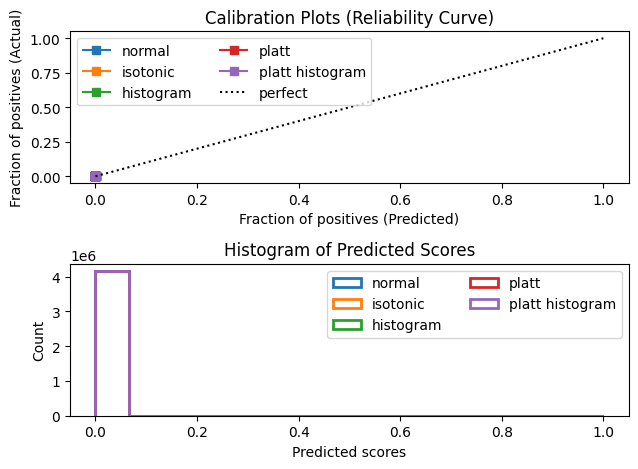

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.9211,0.0021,0.1449,0.0041,0.0007,0.0001,0.0002,normal
1,0.8891,0.0012,0.3110,0.0024,0.0006,0.0001,0.0001,isotonic
2,0.9252,0.0007,0.6396,0.0014,0.0006,0.0001,0.0000,histogram
3,0.9211,0.0021,0.1449,0.0041,0.0007,0.0001,0.0002,platt
4,0.9181,0.0007,0.6396,0.0014,0.0006,0.0001,0.0001,platt histogram


In [ ]:
# divide the dataframes for the calibration process
k = CV_SET_STEP.split("=")[0]
v = int(CV_SET_STEP.split("=")[1])
cvValStep = relativedelta(**{k: v})

train_cutoff = int(
    (datetime.strptime(START_CV_DATE, "%Y%m%d") + NUM_FOLDS * cvValStep)
    .strftime("%Y%m%d")
)
train_df = train_data.filter(F.col("cd_day") < train_cutoff)
val_df = train_data.filter(F.col("cd_day") >= train_cutoff)
test_df = test_data

# re-train the best pipeline
model = best_pipeline.fit(train_df)

# apply transformations
val_pred = model.transform(val_df).select(
    "shortage_flag", extract_prob_udf(F.col("probability")).alias("probability")
).toPandas()
test_pred = model.transform(test_df).select(
    "shortage_flag", extract_prob_udf(F.col("probability")).alias("probability")
).toPandas()

# run the calibration
n_bins = 15
# ISOTONIC
isotonic = IsotonicRegression(
    out_of_bounds="clip", y_min=val_pred["probability"].min(), y_max=val_pred["probability"].max()
)
isotonic.fit(val_pred["probability"].values, val_pred["shortage_flag"].values)
isotonic_probs = isotonic.predict(test_pred["probability"].values)
# HISTOGRAM
histogram = HistogramCalibrator(n_bins=n_bins)
histogram.fit(val_pred["probability"].values, val_pred["shortage_flag"].values)
histogram_probs = histogram.predict(test_pred["probability"].values)
# PLATT
platt = PlattCalibrator(log_odds=False)
platt.fit(val_pred["probability"].values, val_pred["shortage_flag"].values)
platt_probs = platt.predict(test_pred["probability"].values)
# PLATT HISTOGRAM
platt_histogram = PlattHistogramCalibrator(n_bins=n_bins, log_odds=True)
platt_histogram.fit(val_pred["probability"].values, val_pred["shortage_flag"].values)
platt_histogram_probs = platt_histogram.predict(test_pred["probability"].values)

# compute the summary results
labels_test = test_pred["shortage_flag"].values
df_isotonic_eval_test = pd.DataFrame({"shortage_flag": labels_test, "probability": isotonic_probs})
df_histogram_eval_test = pd.DataFrame({"shortage_flag": labels_test, "probability": histogram_probs})
df_platt_eval_test = pd.DataFrame({"shortage_flag": labels_test, "probability": platt_probs})
df_platt_histogram_eval_test = pd.DataFrame({"shortage_flag": labels_test, "probability": platt_histogram_probs})
eval_dict = {
    "normal": test_pred,
    "isotonic": df_isotonic_eval_test,
    "histogram": df_histogram_eval_test,
    "platt": df_platt_eval_test,
    "platt histogram": df_platt_histogram_eval_test,
}
compute_calibration_summary(eval_dict, "shortage_flag", "probability", n_bins=n_bins)

---

# Predict

In [ ]:
predict_df = spark.read.parquet(f"{DATA_PATH}/preprocessed/feng_spark.parquet")
date_max = predict_df.agg(F.max("cd_day")).collect()[0][0]
predict_df = (
    predict_df.filter(F.col("cd_day") == date_max)
    .withColumn("quarter", F.quarter(F.col("date")))
)


platt_histogram = PlattHistogramCalibrator(n_bins=n_bins, log_odds=True)
platt_histogram.fit(test_pred["probability"].values, test_pred["shortage_flag"].values)


probs = platt_histogram.predict(test_pred["probability"].values)

predict_df = (
    best_model.transform(predict_df)
    .select("package_ndc", "date", "shortage_indicator", "probability", "cd_day")
    .withColumn("probability", extract_prob_udf(F.col("probability")))
)
predict_df.write.mode("overwrite").parquet(f"{DATA_PATH}/preprocessed/predict_lr.parquet")

---